In [1]:


###################################################################
# Built-in modules ################################################
###################################################################

import sys

sys.path.append("../../")

import os
import numpy as np
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc

import math
import time
import glob

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.NumbaPatchMatcher import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv
from components.utils.Metrix import Wrapper as me

###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [2]:


ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba"

INIT_METHOD = "maclean"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "450X375"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE=""
YEAR= 2003
EXP_PARAMS = dict()


###  Loading the dataset and visualising the results

['im2.png', 'im6.png', 'disp2.png', 'teddy_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\teddy\im2.png
..\..\datasets\middlebury\middlebury_2003\teddy\im6.png
..\..\datasets\middlebury\middlebury_2003\teddy\disp2.png
..\..\datasets\middlebury\middlebury_2003\teddy\teddy_nonocc.png
['im2.png', 'im6.png', 'disp2.png', 'cones_nonocc.png']
..\..\datasets\middlebury\middlebury_2003\cones\im2.png
..\..\datasets\middlebury\middlebury_2003\cones\im6.png
..\..\datasets\middlebury\middlebury_2003\cones\disp2.png
..\..\datasets\middlebury\middlebury_2003\cones\cones_nonocc.png


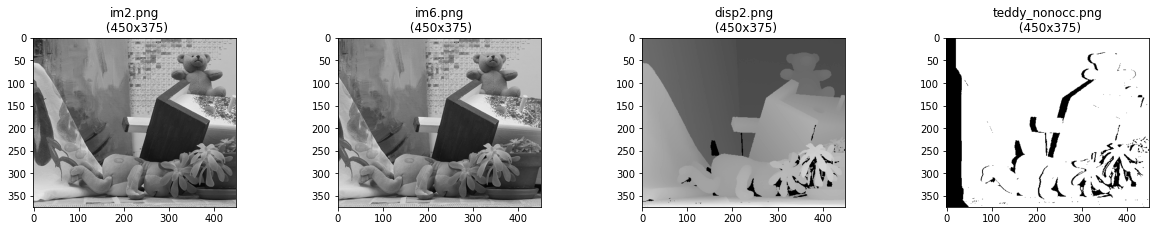

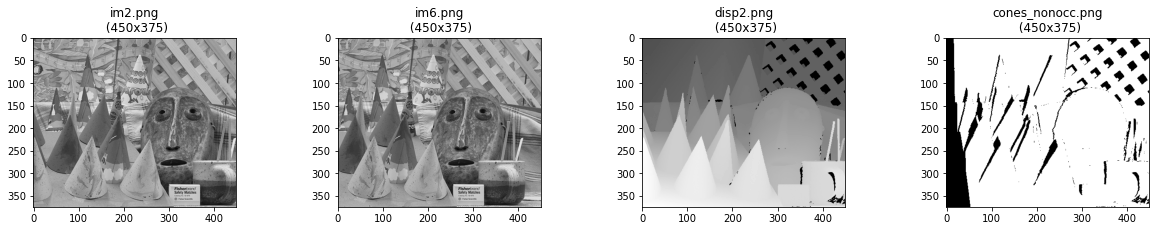

In [3]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

# The addition of occluded areas to the pristine groundtruth images

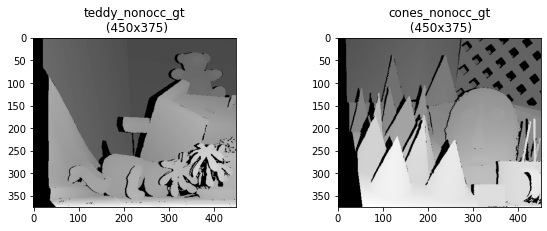

In [4]:
###################################################################
# 2. Occluded areas are added to the groundtruths #################
###################################################################

nonocc_gts = list()
for imgs, paths in loaded_imgs_and_paths:
    temp = mbu.add_masks_to_raw_disparity(imgs[2], imgs[3])
    nonocc_gts.append(mbu.add_masks_to_raw_disparity(imgs[2], imgs[3]))
plu.plot_images(nonocc_gts, ["teddy_nonocc_gt", "cones_nonocc_gt"])

# Benchmarking and evaluation

In [5]:
###################################################################
# 3.1 Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

MATCH = 60
GAP = -20
EGAP = -1


EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

Directory '..\..\experiments\logs' already exists.

In [6]:
###################################################################
# 3.2 Matching ####################################################
###################################################################
from skimage.morphology import disk, diamond, star, octagon
from skimage import filters

results = []
EXP_PARAMS["init_method"] = "maclean_et_al"
patches = dict(    
               #Gaussian filters
               gauss_3_3 = u.gaussian_kernel(3,3,1,1)*9,
               gauss_5_5 = u.gaussian_kernel(5,5,1,1) *25,
               gauss_5_3 = u.gaussian_kernel(5,3,1,1) *15, 
               gauss_7_3 = u.gaussian_kernel(7,3,1,1) *21,
               gauss_11_3 = u.gaussian_kernel(11,3,1,1) *33, 
               gauss_13_3 = u.gaussian_kernel(13,3,1,1) *39,
    
               #Sci-image morphological
               
               star_2=star(2),
               star_3=star(3), 
               octagon_1_3 = octagon(1,3),
               octagon_3_1 = octagon(3,1),
               diamond_2 = diamond(2), 
               diamond_3=diamond(3),
               disk_2=disk(2),
               disk_3=disk(3),
               disk_4=disk(4),
               
               #Farid filters
    
               hfarid = filters.edges.HFARID_WEIGHTS,
               vfarid = filters.edges.VFARID_WEIGHTS,
               hvfarid_div2 = (filters.edges.HFARID_WEIGHTS+filters.edges.VFARID_WEIGHTS)/2,
               hvfarid = (filters.edges.HFARID_WEIGHTS+filters.edges.VFARID_WEIGHTS),
               
               #Sobel filters
    
               hsobel = filters.edges.HSOBEL_WEIGHTS,
               vsobel = filters.edges.VSOBEL_WEIGHTS,
               hvsobel_div2 = (filters.edges.HSOBEL_WEIGHTS+filters.edges.VSOBEL_WEIGHTS)/2,
               hvsobel_div = (filters.edges.HSOBEL_WEIGHTS+filters.edges.VSOBEL_WEIGHTS),
               
               #Scharr filters
    
               hscharr = filters.edges.HSCHARR_WEIGHTS,
               vscharr = filters.edges.VSCHARR_WEIGHTS,
               hvscharr_div2 = (filters.edges.HSCHARR_WEIGHTS+filters.edges.VSCHARR_WEIGHTS)/2,
               hvscharr = (filters.edges.HSCHARR_WEIGHTS+filters.edges.VSCHARR_WEIGHTS),
               
               #Prewitt filters
    
               hprewitt = filters.edges.VPREWITT_WEIGHTS,
               vprewitt = filters.edges.VPREWITT_WEIGHTS,
               hvprewitt_div2 = (filters.edges.VPREWITT_WEIGHTS+filters.edges.HPREWITT_WEIGHTS)/2,
               hvprewitt = (filters.edges.VPREWITT_WEIGHTS+filters.edges.HPREWITT_WEIGHTS)
               )



In [9]:
matcher = m(MATCH, GAP, EGAP)
progress_bar = SimpleProgressBar.get_instance()

progress_counter = 1
steps_to_be_taken = len(SCENES)*len(patches)*4
print("Number of iterations: {0}".format(steps_to_be_taken))

SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)

saved_image_names = []
results = []

Number of iterations: 248


In [10]:
for match_value in range(10, 41, 10):
    for k,p in patches.items():
        for i, scene in enumerate(SCENES):
            # Parameters to be logged...

            EXP_PARAMS["scene"] = scene
            EXP_PARAMS["image_filename"] = IMAGE_FILENAME = loaded_imgs_and_paths[i][1][0]
            EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
            EXP_PARAMS["kernel_size"] = "{0}x{1}".format(p.shape[0], p.shape[1])
            EXP_PARAMS["kernel_spec"] = k

            EXP_PARAMS["match"] = MATCH = match_value
            matcher = m(MATCH, GAP, EGAP)


            occ = loaded_imgs_and_paths[i][0][3]
            gt = loaded_imgs_and_paths[i][0][2]

            matcher.set_images(loaded_imgs_and_paths[i][0][0].astype(np.float64),
                               loaded_imgs_and_paths[i][0][1].astype(np.float64))
            tic = time.time()

            matcher.configure_instance()
            matcher.set_filter(p)

            tic=time.time()

            x,raw_disp_map = matcher.test_pipeline()
            toc = time.time()

            EXP_PARAMS["runtime"] = toc-tic

            disp = raw_disp_map
            disp = 4*disp
            
            temp_path = u.save_disparity(SAVE_PATH, disp)
            saved_image_names.append(os.path.split(temp_path)[-1])
            EXP_PARAMS["image_filename"] = temp_path


            EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False

            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys = csv.get_header_v3())

            EXP_PARAMS["are_occlusions_errors"] = True
            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["BAD8"], EXP_PARAMS["abs_error"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, gt, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys = csv.get_header_v3())
            progress_bar.progress_bar(progress_counter, steps_to_be_taken, header= "Experiment on patch sizes in progress: ", progress_bar_steps=40)
            progress_counter+=1
            results.append(disp)

Experiment on patch sizes in progress:  [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00 % completed: 248 / 248 steps

In [11]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="abs_error", inplace=True) 
experiment_log.head(30)

experiment_id  match  gap  egap  \
124  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     10  -20    -1   
286  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     30  -20    -1   
290  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     30  -20    -1   
282  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     30  -20    -1   
278  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     30  -20    -1   
194  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
186  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
276  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     30  -20    -1   
68   ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     10  -20    -1   
60   ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     10  -20    -1   
152  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
156  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
160  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
164  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
268  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     30  -20    -1   
144  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
148  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
274  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     30  -20    -1   
108  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     10  -20    -1   
270  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     30  -20    -1   
178  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
190  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     20  -20    -1   
126  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     10  -20    -1   
410  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     40  -20    -1   
406  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     40  -20    -1   
414  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     40  -20    -1   
402  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     40  -20    -1   
110  ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     10  -20    -1   
62   ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     10  -20    -1   
70   ALG_005_EXP_002-PatchMatch-MacLean_et_al-Numba     10  -20    -1   

                                      algo    init_method     dataset  scene  \
124  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
286  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
290  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
282  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
278  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
194  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
186  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
276  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
68   components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
60   components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
152  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
156  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
160  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
164  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
268  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
144  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
148  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
274  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
108  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  teddy   
270  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
178  components.matchers.NumbaPatchMatcher  maclean_et_al  middlebury  cones   
190  component

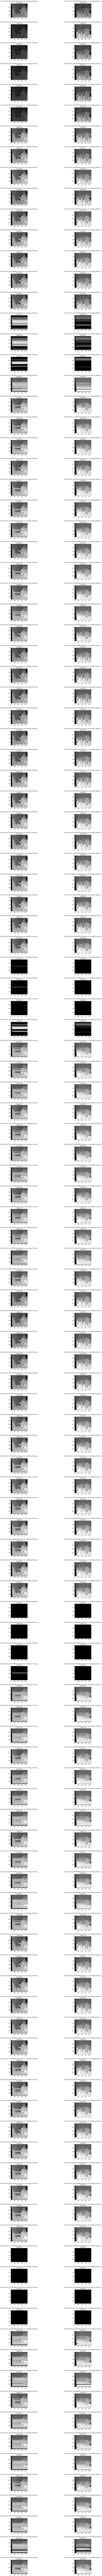

In [12]:
plu.plot_images(results, saved_image_names, ncols=2)